In [2]:
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import plancklens
from plancklens import utils
from plancklens import nhl
from plancklens.n1 import n1
from plancklens import qest, qecl, qresp
import orphics
from orphics import maps, cosmology
import pandas as pd

import symlens as s
import pixell
from pixell import enmap
# from pixell import enmap, curvedsky
# import curvedsky
from math import pi

In [3]:
exps_config = {
    'CMB_S3': {
        'nlev_t': 7,
        'nlev_p': 7*2**0.5,
        'beam_arcmin': 1.4
    },
    'CMB_S4': {
        'nlev_t': 1,
        'nlev_p':2**0.5,
        'beam_arcmin': 3
    }
}

exps_config = {
    'CMB_S4': {
        'nlev_t': 1,
        'nlev_p':2**0.5,
        'beam_arcmin': 1.4
    }
}

moments = {'moments1':{'ellmin':30, 'ellmax':3000, 'delta_L':150},\
           'moments2':{'ellmin':30, 'ellmax':4000, 'delta_L':200}}

ellmin = 30
lmax = 6000
ls = np.arange(0, lmax+1)
fac = (ls*(ls+1))**2/(2*pi)
fac[0] = 1

In [4]:
clpp = np.loadtxt('../inputPs/cosmo2017_10K_acc3_lenspotentialCls.dat', \
                  usecols=(5), unpack=True)
clpp = np.concatenate(([1,1], clpp))[ls]/fac
theory = cosmology.default_theory()
cltt = theory.lCl('TT', ls)
clte = theory.lCl('TE', ls)
clee = theory.lCl('EE', ls)
clbb = theory.lCl('BB', ls)

In [5]:
class bin1D(object):
    def __init__(self, ls, bin_edges):
        self.centers = (bin_edges[1:]+bin_edges[:-1])/2.
        self.digitized = np.digitize(ls, bin_edges,right=True)
        self.bin_edges = bin_edges
    def bin(self,data1d,weights=None):
        if weights is None:
            res = np.bincount(self.digitized,(data1d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]
        else:
            res = np.bincount(self.digitized,(data1d*weights).reshape(-1))[1:-1]/np.bincount(self.digitized,weights.reshape(-1))[1:-1]
        return self.centers,res

def binave(map, modlmap, ellmin, ellmax, delta_l):
    bin_edges = np.arange(ellmin, ellmax+delta_l+1, delta_l)
    binner = s.utils.bin2D(modlmap, bin_edges)

    centers, p1d = binner.bin(map)
    return centers, p1d

In [6]:
shape, wcs = enmap.fullsky_geometry(res=2*pixell.utils.arcmin)

In [7]:
# ellmaxs = [3000]
# for exp, param in exps_config.items():
#     for ellmax in ellmaxs:
#         feed_dict = {}
        
#         map_modlmap = enmap.modlmap(shape, wcs)
#         kbeam = s.utils.gauss_beam(map_modlmap, param['beam_arcmin'])
#         n2d = (param['nlev_p']*np.pi/180./60.)**2./kbeam**2.
        
#         ells = np.arange(0, ellmax+1)
#         feed_dict['uC_E_E'] = s.utils.interp(ells, clee[ells])(map_modlmap)
#         feed_dict['tC_E_E'] = feed_dict['uC_E_E'] + n2d
#         feed_dict['tC_B_B'] = n2d
        
#         cmask = s.utils.mask_kspace(shape, wcs, lmin=ellmin, lmax=ellmax)
#         kmask = s.utils.mask_kspace(shape, wcs, lmin=ellmin, lmax=ellmax)
        
#         norm_k_eb = s.A_l(shape,
#                        wcs,
#                        feed_dict,
#                        "hu_ok",
#                        'EB',
#                        xmask=cmask,
#                        ymask=cmask,
#                        kmask=kmask)
# Ls, norm_tt = binave(norm_k_tt, map_modlmap, ellmin+0.5, ellmax-1, 1)

In [8]:
# Ls, norm_eb = binave(norm_k_eb, map_modlmap, ellmin+0.5, ellmax-1, 1)
# np.savetxt("norm_eb_symlens.txt", norm_eb)

In [9]:
norm_eb_sml = np.loadtxt('norm_eb_symlens.txt')
Al_eb_clp = np.loadtxt('Al_eb_clp.txt')
Ls = np.loadtxt('Ls.txt')

In [10]:
# # use cmblensplus to calculate norm and noise
# ellmaxs = [3000]
# for exp, param in exps_config.items():
#     for ellmax in ellmaxs:
#         clee, clbb = theory.lCl('EE', ls), theory.lCl('BB', ls)
#         nlee = (param['nlev_p']*np.pi/180/60)**2/maps.gauss_beam(ls, param['beam_arcmin'])**2
#         nlbb = nlee
#         oclee = clee + nlee
#         oclbb = clbb + nlbb
#         oclee[0], oclee[1], oclbb[0], oclbb[1] = 1, 1, 1, 1

#         oclee[0], oclee[1], oclbb[0], oclbb[1] = 1, 1, 1, 1
#         Al_eb = curvedsky.norm_quad.qeb('lens', ellmax, ellmin, ellmax, clee[:ellmax+1],\
#                                         oclee[:ellmax+1], oclbb[:ellmax+1], lfac='')                             

In [11]:
# use cmblensplus to calculate norm and noise
ellmaxs = [3000]
for exp, param in exps_config.items():
    for ellmax in ellmaxs:
        cltt = theory.lCl('TT', ls)
        clee, clbb = theory.lCl('EE', ls), theory.lCl('BB', ls)
        
        nltt = (param['nlev_t']*np.pi/180/60)**2/maps.gauss_beam(ls, param['beam_arcmin'])**2
        nlee = (param['nlev_p']*np.pi/180/60)**2/maps.gauss_beam(ls, param['beam_arcmin'])**2
        nlbb = nlee
        
        ocltt = cltt + nltt
        oclee = clee + nlee
        oclbb = clbb + nlbb
        oclee[0], oclee[1], oclbb[0], oclbb[1] = 1, 1, 1, 1

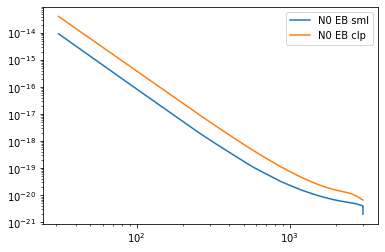

In [12]:
plt.plot(Ls, norm_eb_sml/Ls**2, label='N0 EB sml')
plt.plot(Ls, Al_eb_clp[0][31:], label='N0 EB clp')
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [14]:
ellmaxs = [3000]
for exp, param in exps_config.items():
    for ellmax in ellmaxs:
        0

In [15]:
A_cb_index = '05'

In [17]:
ellmax =3000
claa = np.loadtxt('../inputPs/claa_A1e-%s.txt' %A_cb_index)[:,1]

ftl = utils.cli(ocltt[:ellmax+1])
fel = utils.cli(oclee[:ellmax+1])
fbl = utils.cli(oclbb[:ellmax+1])
ftl[:ellmin] *= 0.
fel[:ellmin] *= 0.
fbl[:ellmin] *= 0.

#---- N1 lensing bias library:
n1_dd = n1.library_n1('.',cltt,clte,clee)
n1aa = n1_dd.get_n1('peb', 'r', claa, ftl, fel, fbl, ellmax)

n1: doing L 1 kA peb kB peb kind r
n1: doing L 2 kA peb kB peb kind r
n1: doing L 3 kA peb kB peb kind r
n1: doing L 4 kA peb kB peb kind r
n1: doing L 5 kA peb kB peb kind r
n1: doing L 6 kA peb kB peb kind r
n1: doing L 7 kA peb kB peb kind r
n1: doing L 8 kA peb kB peb kind r
n1: doing L 9 kA peb kB peb kind r
n1: doing L 10 kA peb kB peb kind r
n1: doing L 21 kA peb kB peb kind r
n1: doing L 41 kA peb kB peb kind r
n1: doing L 61 kA peb kB peb kind r
n1: doing L 81 kA peb kB peb kind r
n1: doing L 101 kA peb kB peb kind r
n1: doing L 121 kA peb kB peb kind r
n1: doing L 141 kA peb kB peb kind r
n1: doing L 161 kA peb kB peb kind r
n1: doing L 181 kA peb kB peb kind r
n1: doing L 201 kA peb kB peb kind r
n1: doing L 221 kA peb kB peb kind r
n1: doing L 241 kA peb kB peb kind r
n1: doing L 261 kA peb kB peb kind r
n1: doing L 281 kA peb kB peb kind r
n1: doing L 301 kA peb kB peb kind r
n1: doing L 321 kA peb kB peb kind r
n1: doing L 341 kA peb kB peb kind r
n1: doing L 361 kA peb k

In [18]:
data = pd.read_csv('./CMB_S4_30_3000_n.csv')
bias = ((data['EB_rot_reckap_x_reckap']-data['EB_reckap_x_reckap'])-(data['EB_rot_rdn0']-data['EB_rdn0']))/\
                 data['EB_inkap_x_inkap']

In [19]:
n1aa_n_clp = (Al_eb_clp[0][31:])**2*n1aa[31:]
n1aa_n_sml = (norm_eb_sml/Ls**2)**2*n1aa[31:]

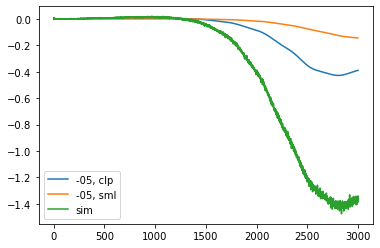

In [20]:
plt.plot(Ls[:-1], n1aa_n_clp[:-1]/clpp[31:3000], label='-%s, clp' %A_cb_index)
plt.plot(Ls[:-2], n1aa_n_sml[:-2]/clpp[31:2999], label='-%s, sml' %A_cb_index)
plt.plot(data['L'], bias, label='sim')
# plt.plot(Ls[Lmin:lmax_ivf], (n1aa_06_n[:lmax_ivf]/clpp_fid[:lmax_ivf])[Lmin:lmax_ivf], label='-06')
plt.legend()

In [11]:
# for exp, param in exps_config.items():
#     for ellmax in ellmaxs:
#         feed_dict = {}
#         map_modlmap = enmap.modlmap(shape, wcs)
#         kbeam = s.utils.gauss_beam(map_modlmap, param['beam_arcmin'])
#         n2d = (param['nlev_t']*np.pi/180./60.)**2./kbeam**2.
        
#         feed_dict['uC_T_T'] = s.utils.interp(ells, clee)(map_modlmap)
#         feed_dict['tC_T_T'] = feed_dict['uC_T_T'] + n2d
        
#         cmask = s.utils.mask_kspace(shape, wcs, lmin=ellmin, lmax=ellmax)
#         kmask = s.utils.mask_kspace(shape, wcs, lmin=ellmin, lmax=ellmax)
        
#         norm_k_tt = s.A_l(shape,
#                        wcs,
#                        feed_dict,
#                        "hu_ok",
#                        'TT',
#                        xmask=cmask,
#                        ymask=cmask,
#                        kmask=kmask)        

In [50]:
# factor = ls**2*(ls+1)**2/(2*np.pi)

# plt.plot(ls[ellmin_plot:ellmax_plot], (factor*clpp_fid[ls])[ellmin_plot:ellmax_plot], label='Clpp')
# plt.plot(Ls, factor_L*norm_tt/Ls**2, label='N0 TT')
# plt.plot(Ls, factor_L*norm_eb/Ls**2, label='N0 EB')
# plt.yscale('log')
# plt.xscale('log')
# plt.legend()

In [53]:
# transf = hp.gauss_beam(5. / 60. / 180. * np.pi, lmax=lmax_ivf) * hp.pixwin(nside)[:lmax_ivf + 1]
# transf = hp.gauss_beam(5. / 60. / 180. * np.pi, lmax=lmax_qlm) * maps.gauss_beam(ls, beam_arcmin)
# ells = np.arange(0, ellmax+1)
transf = hp.gauss_beam(5. / 60. / 180. * np.pi, lmax=ellmax) * maps.gauss_beam(ells, param['beam_arcmin'])

In [13]:
libdir_n1_dd = '.'
# normalize n1
cl_weight = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))
cl_weight['bb'] *= 0.

cl_weight = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))
cl_weight['bb'] *= 0.

qresp_dd = qresp.resp_lib_simple(libdir_n1_dd, ellmax, cl_weight, cl_len,\
                     {'t': ftl, 'e': fel, 'b': fbl}, ellmax)
qc_resp_tt = qresp_dd.get_response('ptt', 'p')**2
qc_resp_eb = qresp_dd.get_response('p_eb', 'p')**2

NameError: name 'cls_path' is not defined

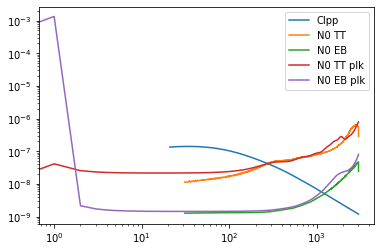

In [210]:
plt.plot(ls[ellmin_plot:ellmax_plot], (factor*clpp_fid[ls])[ellmin_plot:ellmax_plot], label='Clpp')
plt.plot(Ls, factor_L*norm_tt/Ls**2, label='N0 TT')
plt.plot(Ls, factor_L*norm_eb/Ls**2, label='N0 EB')

factor_ells = ells**2*(ells+1)**2/(2*np.pi)**2
plt.plot(ells, factor_ells*utils.cli(qresp_dd.get_response('ptt', 'p')[ells]), label='N0 TT plk')
plt.plot(ells, factor_ells*utils.cli(qresp_dd.get_response('p_eb', 'p')[ells]), label='N0 EB plk')
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [201]:
# n1aa_05 = n1_dd.get_n1('reb', 'p', claa_05, ftl, fel, fbl, lmax_ivf-1)
# n1aa_06 = n1_dd.get_n1('reb', 'p', claa_06, ftl, fel, fbl, lmax_ivf-1)
# n1pp_tt = n1_dd.get_n1('ptt', 'p', clpp_fid, ftl, fel, fbl, lmax_ivf-1)
# n1pp_eb = n1_dd.get_n1('peb', 'p', clpp_fid, ftl, fel, fbl, lmax_ivf-1)

In [202]:
# n1aa_06 = n1_dd.get_n1('peb', 'r', claa_06, ftl, fel, fbl, lmax_ivf-1)
n1aa_07 = n1_dd.get_n1('peb', 'r', claa_07, ftl, fel, fbl, ellmax)

In [203]:
# n1pp_tt_n = utils.cli(qc_resp_tt)[:lmax_ivf]*n1pp_tt
# n1pp_eb_n = utils.cli(qc_resp_eb)[:lmax_ivf]*n1pp_eb
# n1aa_06_n = utils.cli(qc_resp_eb)[:lmax_ivf]*n1aa_06
# n1aa_07_n = utils.cli(qc_resp_eb)[:ellmax+1]*n1aa_07
n1aa_07_n = ((norm_eb*2*np.pi)/Ls**2)**2*n1aa_07[31:]

In [204]:
# plt.plot(Ls[Lmin:lmax_ivf], (factor*clpp_fid[:lmax_ivf])[Lmin:lmax_ivf])
# plt.plot(Ls[Lmin:lmax_ivf], (factor*n1pp_tt_n)[Lmin:lmax_ivf], label='n1tt')
# plt.plot(Ls[Lmin:lmax_ivf], (factor*n1pp_eb_n)[Lmin:lmax_ivf], label='n1eb')
# plt.plot(Ls[Lmin:lmax_ivf], abs((factor*n1aa_07_n)[Lmin:lmax_ivf]), label='n1eb aa')

# plt.xscale('log')
# plt.yscale('log')
# plt.legend()

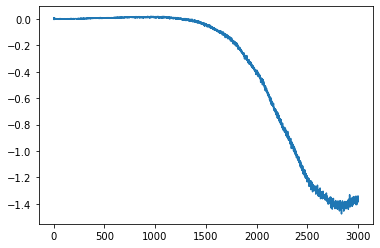

In [206]:
plt.plot(bias)